# Advanced line detection

## Import packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

%load_ext autoreload
%autoreload 2

from calibration import *
from pipeline import *
from helpers import *
from line import *

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Camera Calibration

### Helper functions

Helpers function are defined in helpers.py file

### Load and display images for calibration:

In [ ]:
calibration_image_list = {}

for i,fileName in enumerate(os.listdir("camera_cal/")):
    image = mpimg.imread('camera_cal/' + fileName)
    calibration_image_list[fileName] = image
    
plot_images_map(calibration_image_list)

### Calibrate the camera

Show calibrated images, real calibration is in calibration.py

In [ ]:
undistored_images = {}

# undistort calibration images
for file_name in images_with_corners:
    image = mpimg.imread(file_name)        
    undistored_images[file_name] = cv2.undistort(image, mtx, dist, None, mtx) 

print("found ", len(images_with_corners), "image(s) with corners in ", len(calibration_image_list), "images and undistored ", len(undistored_images))    

### Show images with cornes

In [ ]:
plot_images_map(images_with_corners)

### Show undistored images 

In [ ]:
plot_images_map(undistored_images)

## Example of calibration

In [ ]:
# plot big images of "original" and "undistorted" for "camera_cal/calibration4.jpg"
image = mpimg.imread("camera_cal/calibration1.jpg")
undistorted = cv2.undistort(image, mtx, dist, None, mtx)
plot_images_map({"original" : image, "undistorted" : undistorted}, columns=2, img_size=(40, 110))


# Process test images

## Load and display images

In [ ]:
test_images = {}
undistorted_test_images = {}

for i,fileName in enumerate(os.listdir("test_images/")):
    image = mpimg.imread('test_images/' + fileName)
    test_images[fileName] = image
    undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
    test_images[fileName + "-undistorted"] = undistorted_image
    undistorted_test_images[fileName] = undistorted_image
    
plot_images_map(test_images, columns=2, img_size=(40, 110))

### HLS thresholding

In [ ]:
channels = {}
for file_name in undistorted_test_images :
    img = undistorted_test_images[file_name]
    channels[file_name + "original"] = img
    channels[file_name + "h"] = hls_select(img)
    channels[file_name + "l"] = hls_select(img, channel=1)
    channels[file_name + "s"] = hls_select(img, channel=2)

plot_images_map(channels, columns=4, img_size=(30, 50))

### Pipelines

#### videos

In [2]:
challenge_video_output = 'results/challenge_video.mp4'
harder_challenge_video_output = 'results/harder_challenge_video.mp4'
project_video_output = 'results/project_video.mp4'

challenge_video = VideoFileClip("challenge_video.mp4")
harder_challenge_video = VideoFileClip("harder_challenge_video.mp4")
project_video = VideoFileClip("project_video.mp4")


#### Get frames from the videos for analysis

In [ ]:
for i in range(0,170):
    image = challenge_video.get_frame(i/2.0)
    cv2.imwrite('test_images_extra/challenge_video_{0}.jpg'.format(i), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

for i in range(0,170):
    image = harder_challenge_video.get_frame(i/2.0)
    cv2.imwrite('test_images_extra/harder_challenge_video_{0}.jpg'.format(i), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    
for i in range(0,170):
    image = project_video.get_frame(i/2.0)
    cv2.imwrite('test_images_extra/project_video_{0}.jpg'.format(i), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

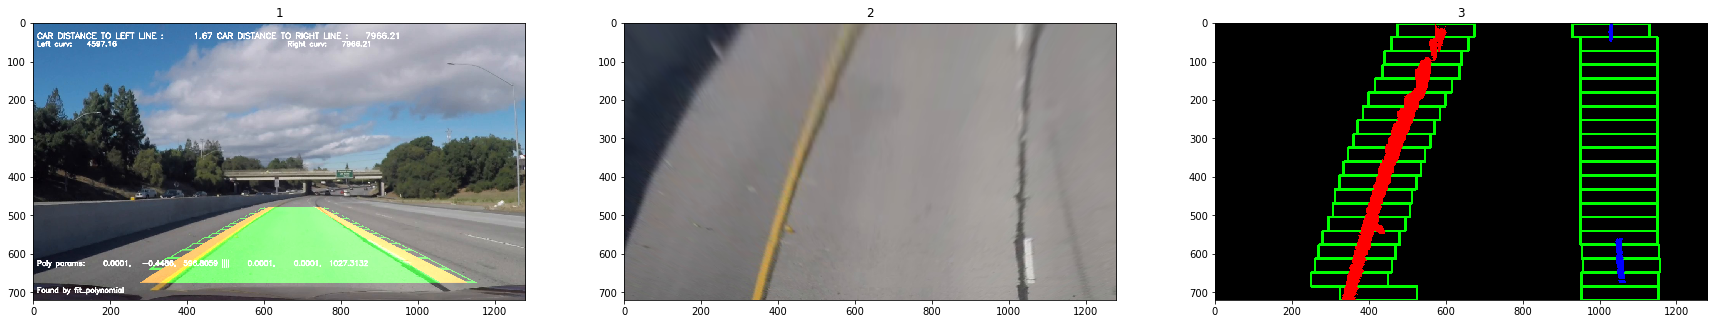

In [12]:
image = mpimg.imread('test_images_extra/challenge_video_0.jpg')
res = pipeline(image)
plot_images_map({"1":res[0], "2":res[1], "3":res[2] }, columns=3, img_size=(30, 50))

In [4]:
def process_image(image):
    return pipeline(image)[0]

In [5]:
challenge_video_output = 'results/challenge_video.mp4'
harder_challenge_video_output = 'results/harder_challenge_video.mp4'
project_video_output = 'results/project_video.mp4'

challenge_video = VideoFileClip("challenge_video.mp4")
harder_challenge_video = VideoFileClip("harder_challenge_video.mp4")
project_video = VideoFileClip("project_video.mp4")

# Process videos

In [20]:
challenge_video_clip = challenge_video.fl_image(process_image) 
%time challenge_video_clip.write_videofile(challenge_video_output, audio=False)

[MoviePy] >>>> Building video results/challenge_video.mp4
[MoviePy] Writing video results/challenge_video.mp4




  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 2/485 [00:00<00:42, 11.26it/s]

  1%|          | 4/485 [00:00<00:41, 11.47it/s]

  1%|          | 6/485 [00:00<00:41, 11.53it/s]

  2%|▏         | 8/485 [00:00<00:41, 11.39it/s]

  2%|▏         | 10/485 [00:00<00:41, 11.44it/s]

  2%|▏         | 12/485 [00:01<00:40, 11.54it/s]

  3%|▎         | 14/485 [00:01<00:40, 11.60it/s]

  3%|▎         | 16/485 [00:01<00:40, 11.59it/s]

  4%|▎         | 18/485 [00:01<00:40, 11.60it/s]

  4%|▍         | 20/485 [00:01<00:39, 11.65it/s]

  5%|▍         | 22/485 [00:01<00:39, 11.67it/s]

  5%|▍         | 24/485 [00:02<00:39, 11.72it/s]

  5%|▌         | 26/485 [00:02<00:39, 11.73it/s]

  6%|▌         | 28/485 [00:02<00:38, 11.78it/s]

  6%|▌         | 30/485 [00:02<00:38, 11.96it/s]

  7%|▋         | 32/485 [00:02<00:37, 11.97it/s]

  7%|▋         | 34/485 [00:02<00:37, 11.96it/s]

  7%|▋         | 36/485 [00:03<00:37, 11.89it/s]

  8%|▊         | 38/485 [00:03<00:37, 11.85it/s]

  8%|▊     

 49%|████▉     | 240/485 [00:23<00:23, 10.29it/s]

 50%|████▉     | 242/485 [00:23<00:23, 10.20it/s]

 50%|█████     | 244/485 [00:23<00:23, 10.34it/s]

 51%|█████     | 246/485 [00:23<00:22, 10.62it/s]

 51%|█████     | 248/485 [00:23<00:21, 10.78it/s]

 52%|█████▏    | 250/485 [00:24<00:21, 10.77it/s]

 52%|█████▏    | 252/485 [00:24<00:21, 10.74it/s]

 52%|█████▏    | 254/485 [00:24<00:21, 10.69it/s]

 53%|█████▎    | 256/485 [00:24<00:21, 10.77it/s]

 53%|█████▎    | 258/485 [00:24<00:21, 10.54it/s]

 54%|█████▎    | 260/485 [00:25<00:21, 10.61it/s]

 54%|█████▍    | 262/485 [00:25<00:21, 10.59it/s]

 54%|█████▍    | 264/485 [00:25<00:20, 10.72it/s]

 55%|█████▍    | 266/485 [00:25<00:20, 10.61it/s]

 55%|█████▌    | 268/485 [00:25<00:20, 10.74it/s]

 56%|█████▌    | 270/485 [00:25<00:20, 10.70it/s]

 56%|█████▌    | 272/485 [00:26<00:19, 10.90it/s]

 56%|█████▋    | 274/485 [00:26<00:19, 10.82it/s]

 57%|█████▋    | 276/485 [00:26<00:19, 10.90it/s]

 57%|█████▋    | 278/485 [00:26

 92%|█████████▏| 444/485 [00:43<00:04,  8.73it/s]

 92%|█████████▏| 445/485 [00:44<00:04,  8.61it/s]

 92%|█████████▏| 446/485 [00:44<00:04,  8.96it/s]

 92%|█████████▏| 447/485 [00:44<00:04,  9.11it/s]

 92%|█████████▏| 448/485 [00:44<00:04,  8.85it/s]

 93%|█████████▎| 449/485 [00:44<00:04,  8.86it/s]

 93%|█████████▎| 450/485 [00:44<00:03,  9.11it/s]

 93%|█████████▎| 451/485 [00:44<00:03,  8.96it/s]

 93%|█████████▎| 452/485 [00:44<00:03,  8.89it/s]

 93%|█████████▎| 453/485 [00:44<00:03,  8.83it/s]

 94%|█████████▎| 454/485 [00:45<00:03,  8.83it/s]

 94%|█████████▍| 455/485 [00:45<00:03,  8.91it/s]

 94%|█████████▍| 456/485 [00:45<00:03,  8.84it/s]

 94%|█████████▍| 457/485 [00:45<00:03,  8.89it/s]

 94%|█████████▍| 458/485 [00:45<00:03,  8.99it/s]

 95%|█████████▍| 459/485 [00:45<00:02,  9.09it/s]

 95%|█████████▍| 460/485 [00:45<00:02,  8.95it/s]

 95%|█████████▌| 461/485 [00:45<00:02,  9.12it/s]

 95%|█████████▌| 462/485 [00:45<00:02,  9.08it/s]

 95%|█████████▌| 463/485 [00:46

[MoviePy] Done.
[MoviePy] >>>> Video ready: results/challenge_video.mp4 

CPU times: user 3min 20s, sys: 12 s, total: 3min 33s
Wall time: 49.1 s


In [22]:
harder_challenge_video_clip = harder_challenge_video.fl_image(process_image) 
%time harder_challenge_video_clip.write_videofile(harder_challenge_video_output, audio=False)

[MoviePy] >>>> Building video results/harder_challenge_video.mp4
[MoviePy] Writing video results/harder_challenge_video.mp4




  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 1/1200 [00:00<03:53,  5.13it/s]

  0%|          | 2/1200 [00:00<03:44,  5.33it/s]

  0%|          | 3/1200 [00:00<03:37,  5.49it/s]

  0%|          | 4/1200 [00:00<03:35,  5.56it/s]

  0%|          | 5/1200 [00:00<03:34,  5.56it/s]

  0%|          | 6/1200 [00:01<03:34,  5.58it/s]

  1%|          | 7/1200 [00:01<03:32,  5.61it/s]

  1%|          | 8/1200 [00:01<03:34,  5.55it/s]

  1%|          | 9/1200 [00:01<03:36,  5.51it/s]

  1%|          | 10/1200 [00:01<03:37,  5.46it/s]

  1%|          | 11/1200 [00:01<03:40,  5.39it/s]

  1%|          | 12/1200 [00:02<03:43,  5.31it/s]

  1%|          | 13/1200 [00:02<03:47,  5.23it/s]

  1%|          | 14/1200 [00:02<03:50,  5.14it/s]

  1%|▏         | 15/1200 [00:02<03:55,  5.02it/s]

  1%|▏         | 16/1200 [00:03<03:58,  4.96it/s]

  1%|▏         | 17/1200 [00:03<04:01,  4.90it/s]

  2%|▏         | 18/1200 [00:03<04:02,  4.88it/s]

  2%|▏         | 19/1200 [00:03<04:06,  4.80it/

 12%|█▏        | 143/1200 [00:30<03:01,  5.81it/s]

 12%|█▏        | 144/1200 [00:30<03:01,  5.82it/s]

 12%|█▏        | 145/1200 [00:30<02:59,  5.88it/s]

 12%|█▏        | 146/1200 [00:30<02:57,  5.95it/s]

 12%|█▏        | 147/1200 [00:31<02:52,  6.12it/s]

 12%|█▏        | 148/1200 [00:31<02:52,  6.09it/s]

 12%|█▏        | 149/1200 [00:31<02:56,  5.94it/s]

 12%|█▎        | 150/1200 [00:31<02:59,  5.86it/s]

 13%|█▎        | 151/1200 [00:31<03:00,  5.82it/s]

 13%|█▎        | 152/1200 [00:31<02:58,  5.88it/s]

 13%|█▎        | 153/1200 [00:32<02:52,  6.07it/s]

 13%|█▎        | 154/1200 [00:32<02:52,  6.05it/s]

 13%|█▎        | 155/1200 [00:32<02:52,  6.04it/s]

 13%|█▎        | 156/1200 [00:32<02:51,  6.09it/s]

 13%|█▎        | 157/1200 [00:32<02:49,  6.17it/s]

 13%|█▎        | 158/1200 [00:32<02:46,  6.25it/s]

 13%|█▎        | 159/1200 [00:33<02:49,  6.15it/s]

 13%|█▎        | 160/1200 [00:33<02:49,  6.12it/s]

 13%|█▎        | 161/1200 [00:33<02:50,  6.11it/s]

 14%|█▎     

 24%|██▎       | 284/1200 [00:55<02:42,  5.65it/s]

 24%|██▍       | 285/1200 [00:56<02:42,  5.64it/s]

 24%|██▍       | 286/1200 [00:56<02:39,  5.73it/s]

 24%|██▍       | 287/1200 [00:56<02:34,  5.92it/s]

 24%|██▍       | 288/1200 [00:56<02:32,  5.97it/s]

 24%|██▍       | 289/1200 [00:56<02:35,  5.86it/s]

 24%|██▍       | 290/1200 [00:56<02:32,  5.98it/s]

 24%|██▍       | 291/1200 [00:57<02:28,  6.13it/s]

 24%|██▍       | 292/1200 [00:57<02:25,  6.25it/s]

 24%|██▍       | 293/1200 [00:57<02:27,  6.16it/s]

 24%|██▍       | 294/1200 [00:57<02:27,  6.15it/s]

 25%|██▍       | 295/1200 [00:57<02:32,  5.94it/s]

 25%|██▍       | 296/1200 [00:57<02:31,  5.96it/s]

 25%|██▍       | 297/1200 [00:58<02:28,  6.08it/s]

 25%|██▍       | 298/1200 [00:58<02:25,  6.20it/s]

 25%|██▍       | 299/1200 [00:58<02:21,  6.35it/s]

 25%|██▌       | 300/1200 [00:58<02:19,  6.43it/s]

 25%|██▌       | 301/1200 [00:58<02:19,  6.46it/s]

 25%|██▌       | 302/1200 [00:58<02:20,  6.37it/s]

 25%|██▌    

 35%|███▌      | 425/1200 [01:24<03:05,  4.18it/s]

 36%|███▌      | 426/1200 [01:24<03:04,  4.19it/s]

 36%|███▌      | 427/1200 [01:24<03:04,  4.19it/s]

 36%|███▌      | 428/1200 [01:25<03:04,  4.19it/s]

 36%|███▌      | 429/1200 [01:25<03:08,  4.10it/s]

 36%|███▌      | 430/1200 [01:25<03:12,  4.01it/s]

 36%|███▌      | 431/1200 [01:25<03:09,  4.05it/s]

 36%|███▌      | 432/1200 [01:26<03:06,  4.12it/s]

 36%|███▌      | 433/1200 [01:26<03:04,  4.16it/s]

 36%|███▌      | 434/1200 [01:26<03:02,  4.19it/s]

 36%|███▋      | 435/1200 [01:26<03:02,  4.20it/s]

 36%|███▋      | 436/1200 [01:26<02:55,  4.35it/s]

 36%|███▋      | 437/1200 [01:27<02:53,  4.40it/s]

 36%|███▋      | 438/1200 [01:27<02:50,  4.47it/s]

 37%|███▋      | 439/1200 [01:27<02:47,  4.55it/s]

 37%|███▋      | 440/1200 [01:27<02:48,  4.50it/s]

 37%|███▋      | 441/1200 [01:27<02:43,  4.63it/s]

 37%|███▋      | 442/1200 [01:28<02:44,  4.61it/s]

 37%|███▋      | 443/1200 [01:28<02:43,  4.63it/s]

 37%|███▋   

 47%|████▋     | 566/1200 [01:47<01:33,  6.80it/s]

 47%|████▋     | 567/1200 [01:48<01:34,  6.69it/s]

 47%|████▋     | 568/1200 [01:48<01:33,  6.79it/s]

 47%|████▋     | 569/1200 [01:48<01:31,  6.92it/s]

 48%|████▊     | 570/1200 [01:48<01:29,  7.02it/s]

 48%|████▊     | 571/1200 [01:48<01:30,  6.94it/s]

 48%|████▊     | 572/1200 [01:48<01:31,  6.83it/s]

 48%|████▊     | 573/1200 [01:48<01:29,  6.99it/s]

 48%|████▊     | 574/1200 [01:49<01:27,  7.12it/s]

 48%|████▊     | 575/1200 [01:49<01:26,  7.25it/s]

 48%|████▊     | 576/1200 [01:49<01:28,  7.06it/s]

 48%|████▊     | 577/1200 [01:49<01:27,  7.14it/s]

 48%|████▊     | 578/1200 [01:49<01:26,  7.20it/s]

 48%|████▊     | 579/1200 [01:49<01:24,  7.33it/s]

 48%|████▊     | 580/1200 [01:49<01:23,  7.41it/s]

 48%|████▊     | 581/1200 [01:49<01:23,  7.44it/s]

 48%|████▊     | 582/1200 [01:50<01:21,  7.56it/s]

 49%|████▊     | 583/1200 [01:50<01:20,  7.67it/s]

 49%|████▊     | 584/1200 [01:50<01:19,  7.73it/s]

 49%|████▉  

 59%|█████▉    | 707/1200 [02:10<00:59,  8.34it/s]

 59%|█████▉    | 708/1200 [02:10<00:58,  8.48it/s]

 59%|█████▉    | 709/1200 [02:10<00:57,  8.49it/s]

 59%|█████▉    | 710/1200 [02:10<00:57,  8.46it/s]

 59%|█████▉    | 711/1200 [02:10<00:57,  8.55it/s]

 59%|█████▉    | 712/1200 [02:10<00:59,  8.26it/s]

 59%|█████▉    | 713/1200 [02:10<01:02,  7.85it/s]

 60%|█████▉    | 714/1200 [02:11<01:02,  7.76it/s]

 60%|█████▉    | 715/1200 [02:11<01:02,  7.71it/s]

 60%|█████▉    | 716/1200 [02:11<01:04,  7.51it/s]

 60%|█████▉    | 717/1200 [02:11<01:05,  7.34it/s]

 60%|█████▉    | 718/1200 [02:11<01:05,  7.35it/s]

 60%|█████▉    | 719/1200 [02:11<01:05,  7.33it/s]

 60%|██████    | 720/1200 [02:11<01:05,  7.31it/s]

 60%|██████    | 721/1200 [02:12<01:06,  7.22it/s]

 60%|██████    | 722/1200 [02:12<01:07,  7.12it/s]

 60%|██████    | 723/1200 [02:12<01:04,  7.42it/s]

 60%|██████    | 724/1200 [02:12<01:03,  7.45it/s]

 60%|██████    | 725/1200 [02:12<01:02,  7.55it/s]

 60%|██████ 

 71%|███████   | 848/1200 [02:30<00:50,  6.95it/s]

 71%|███████   | 849/1200 [02:30<00:52,  6.67it/s]

 71%|███████   | 850/1200 [02:30<00:52,  6.62it/s]

 71%|███████   | 851/1200 [02:31<00:53,  6.50it/s]

 71%|███████   | 852/1200 [02:31<00:53,  6.46it/s]

 71%|███████   | 853/1200 [02:31<00:54,  6.37it/s]

 71%|███████   | 854/1200 [02:31<00:56,  6.13it/s]

 71%|███████▏  | 855/1200 [02:31<00:56,  6.14it/s]

 71%|███████▏  | 856/1200 [02:31<00:55,  6.19it/s]

 71%|███████▏  | 857/1200 [02:32<00:56,  6.11it/s]

 72%|███████▏  | 858/1200 [02:32<00:58,  5.88it/s]

 72%|███████▏  | 859/1200 [02:32<00:59,  5.74it/s]

 72%|███████▏  | 860/1200 [02:32<01:00,  5.67it/s]

 72%|███████▏  | 861/1200 [02:32<00:59,  5.65it/s]

 72%|███████▏  | 862/1200 [02:32<01:01,  5.50it/s]

 72%|███████▏  | 863/1200 [02:33<01:00,  5.59it/s]

 72%|███████▏  | 864/1200 [02:33<01:00,  5.55it/s]

 72%|███████▏  | 865/1200 [02:33<01:00,  5.58it/s]

 72%|███████▏  | 866/1200 [02:33<00:59,  5.62it/s]

 72%|███████

 82%|████████▏ | 989/1200 [02:50<00:23,  8.81it/s]

 82%|████████▎ | 990/1200 [02:50<00:23,  8.82it/s]

 83%|████████▎ | 991/1200 [02:50<00:23,  8.84it/s]

 83%|████████▎ | 992/1200 [02:50<00:23,  8.81it/s]

 83%|████████▎ | 993/1200 [02:50<00:23,  9.00it/s]

 83%|████████▎ | 994/1200 [02:51<00:22,  9.07it/s]

 83%|████████▎ | 995/1200 [02:51<00:23,  8.90it/s]

 83%|████████▎ | 996/1200 [02:51<00:23,  8.84it/s]

 83%|████████▎ | 997/1200 [02:51<00:22,  8.88it/s]

 83%|████████▎ | 998/1200 [02:51<00:22,  9.02it/s]

 83%|████████▎ | 999/1200 [02:51<00:22,  9.01it/s]

 83%|████████▎ | 1000/1200 [02:51<00:22,  9.07it/s]

 83%|████████▎ | 1001/1200 [02:51<00:21,  9.08it/s]

 84%|████████▎ | 1002/1200 [02:51<00:21,  9.16it/s]

 84%|████████▎ | 1004/1200 [02:52<00:21,  9.29it/s]

 84%|████████▍ | 1005/1200 [02:52<00:21,  8.95it/s]

 84%|████████▍ | 1006/1200 [02:52<00:21,  8.83it/s]

 84%|████████▍ | 1007/1200 [02:52<00:21,  8.79it/s]

 84%|████████▍ | 1008/1200 [02:52<00:22,  8.69it/s]

 84%

 94%|█████████▍| 1129/1200 [03:10<00:09,  7.65it/s]

 94%|█████████▍| 1130/1200 [03:10<00:09,  7.72it/s]

 94%|█████████▍| 1131/1200 [03:10<00:08,  7.68it/s]

 94%|█████████▍| 1132/1200 [03:10<00:08,  7.64it/s]

 94%|█████████▍| 1133/1200 [03:10<00:08,  7.72it/s]

 94%|█████████▍| 1134/1200 [03:10<00:08,  7.75it/s]

 95%|█████████▍| 1135/1200 [03:10<00:08,  7.87it/s]

 95%|█████████▍| 1136/1200 [03:10<00:08,  7.92it/s]

 95%|█████████▍| 1137/1200 [03:11<00:08,  7.74it/s]

 95%|█████████▍| 1138/1200 [03:11<00:07,  7.88it/s]

 95%|█████████▍| 1139/1200 [03:11<00:07,  7.94it/s]

 95%|█████████▌| 1140/1200 [03:11<00:07,  7.74it/s]

 95%|█████████▌| 1141/1200 [03:11<00:07,  7.59it/s]

 95%|█████████▌| 1142/1200 [03:11<00:07,  7.66it/s]

 95%|█████████▌| 1143/1200 [03:11<00:07,  7.64it/s]

 95%|█████████▌| 1144/1200 [03:11<00:07,  7.45it/s]

 95%|█████████▌| 1145/1200 [03:12<00:07,  7.25it/s]

 96%|█████████▌| 1146/1200 [03:12<00:07,  7.46it/s]

 96%|█████████▌| 1147/1200 [03:12<00:06,  7.68

[MoviePy] Done.
[MoviePy] >>>> Video ready: results/harder_challenge_video.mp4 

CPU times: user 13min 31s, sys: 47.2 s, total: 14min 18s
Wall time: 8min 43s


In [21]:
project_video_clip = project_video.fl_image(process_image) 
%time project_video_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video results/project_video.mp4
[MoviePy] Writing video results/project_video.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 2/1261 [00:00<01:54, 11.01it/s]

  0%|          | 4/1261 [00:00<01:53, 11.06it/s]

  0%|          | 5/1261 [00:00<01:57, 10.69it/s]

  0%|          | 6/1261 [00:00<02:01, 10.33it/s]

  1%|          | 8/1261 [00:00<01:59, 10.52it/s]

  1%|          | 10/1261 [00:00<01:59, 10.47it/s]

  1%|          | 12/1261 [00:01<01:57, 10.66it/s]

  1%|          | 14/1261 [00:01<01:55, 10.81it/s]

  1%|▏         | 16/1261 [00:01<01:55, 10.82it/s]

  1%|▏         | 18/1261 [00:01<01:52, 11.05it/s]

  2%|▏         | 20/1261 [00:01<01:54, 10.82it/s]

  2%|▏         | 22/1261 [00:02<01:53, 10.91it/s]

  2%|▏         | 24/1261 [00:02<01:51, 11.09it/s]

  2%|▏         | 26/1261 [00:02<01:50, 11.13it/s]

  2%|▏         | 28/1261 [00:02<01:50, 11.19it/s]

  2%|▏         | 30/1261 [00:02<01:48, 11.34it/s]

  3%|▎         | 32/1261 [00:02<01:48, 11.37it/s]

  3%|▎         | 34/1261 [00:03<01:47, 11.36it/s]

  3%|▎         | 36/1261 [00:03<01:47, 11.3

 14%|█▍        | 181/1261 [00:19<02:13,  8.11it/s]

 14%|█▍        | 182/1261 [00:19<02:11,  8.21it/s]

 15%|█▍        | 183/1261 [00:19<02:07,  8.45it/s]

 15%|█▍        | 184/1261 [00:19<02:11,  8.18it/s]

 15%|█▍        | 185/1261 [00:20<02:11,  8.21it/s]

 15%|█▍        | 186/1261 [00:20<02:08,  8.34it/s]

 15%|█▍        | 187/1261 [00:20<02:06,  8.52it/s]

 15%|█▍        | 188/1261 [00:20<02:06,  8.49it/s]

 15%|█▍        | 189/1261 [00:20<02:06,  8.49it/s]

 15%|█▌        | 190/1261 [00:20<02:05,  8.56it/s]

 15%|█▌        | 191/1261 [00:20<02:03,  8.70it/s]

 15%|█▌        | 192/1261 [00:20<02:04,  8.56it/s]

 15%|█▌        | 193/1261 [00:21<02:07,  8.41it/s]

 15%|█▌        | 194/1261 [00:21<02:06,  8.42it/s]

 15%|█▌        | 195/1261 [00:21<02:05,  8.51it/s]

 16%|█▌        | 196/1261 [00:21<02:08,  8.31it/s]

 16%|█▌        | 197/1261 [00:21<02:10,  8.13it/s]

 16%|█▌        | 198/1261 [00:21<02:09,  8.19it/s]

 16%|█▌        | 199/1261 [00:21<02:07,  8.30it/s]

 16%|█▌     

 26%|██▌       | 322/1261 [00:36<01:55,  8.10it/s]

 26%|██▌       | 323/1261 [00:36<01:56,  8.03it/s]

 26%|██▌       | 324/1261 [00:36<01:53,  8.28it/s]

 26%|██▌       | 325/1261 [00:37<01:51,  8.42it/s]

 26%|██▌       | 326/1261 [00:37<01:50,  8.46it/s]

 26%|██▌       | 327/1261 [00:37<01:49,  8.50it/s]

 26%|██▌       | 328/1261 [00:37<01:47,  8.70it/s]

 26%|██▌       | 329/1261 [00:37<01:47,  8.69it/s]

 26%|██▌       | 330/1261 [00:37<01:48,  8.57it/s]

 26%|██▌       | 331/1261 [00:37<01:49,  8.50it/s]

 26%|██▋       | 332/1261 [00:37<01:47,  8.61it/s]

 26%|██▋       | 333/1261 [00:37<01:47,  8.64it/s]

 26%|██▋       | 334/1261 [00:38<01:48,  8.52it/s]

 27%|██▋       | 335/1261 [00:38<01:49,  8.45it/s]

 27%|██▋       | 336/1261 [00:38<01:49,  8.45it/s]

 27%|██▋       | 337/1261 [00:38<01:48,  8.50it/s]

 27%|██▋       | 338/1261 [00:38<01:51,  8.25it/s]

 27%|██▋       | 339/1261 [00:38<01:52,  8.19it/s]

 27%|██▋       | 340/1261 [00:38<01:49,  8.41it/s]

 27%|██▋    

 37%|███▋      | 463/1261 [00:54<01:50,  7.22it/s]

 37%|███▋      | 464/1261 [00:54<01:50,  7.21it/s]

 37%|███▋      | 465/1261 [00:55<01:47,  7.37it/s]

 37%|███▋      | 466/1261 [00:55<01:50,  7.21it/s]

 37%|███▋      | 467/1261 [00:55<01:51,  7.10it/s]

 37%|███▋      | 468/1261 [00:55<01:50,  7.19it/s]

 37%|███▋      | 469/1261 [00:55<01:48,  7.30it/s]

 37%|███▋      | 470/1261 [00:55<01:49,  7.20it/s]

 37%|███▋      | 471/1261 [00:55<01:50,  7.14it/s]

 37%|███▋      | 472/1261 [00:56<01:48,  7.27it/s]

 38%|███▊      | 473/1261 [00:56<01:47,  7.32it/s]

 38%|███▊      | 474/1261 [00:56<01:48,  7.28it/s]

 38%|███▊      | 475/1261 [00:56<01:47,  7.30it/s]

 38%|███▊      | 476/1261 [00:56<01:47,  7.33it/s]

 38%|███▊      | 477/1261 [00:56<01:44,  7.48it/s]

 38%|███▊      | 478/1261 [00:56<01:49,  7.15it/s]

 38%|███▊      | 479/1261 [00:56<01:49,  7.17it/s]

 38%|███▊      | 480/1261 [00:57<01:50,  7.07it/s]

 38%|███▊      | 481/1261 [00:57<01:50,  7.04it/s]

 38%|███▊   

 48%|████▊     | 604/1261 [01:16<01:30,  7.23it/s]

 48%|████▊     | 605/1261 [01:16<01:30,  7.22it/s]

 48%|████▊     | 606/1261 [01:16<01:28,  7.41it/s]

 48%|████▊     | 607/1261 [01:16<01:26,  7.57it/s]

 48%|████▊     | 608/1261 [01:17<01:25,  7.63it/s]

 48%|████▊     | 609/1261 [01:17<01:26,  7.51it/s]

 48%|████▊     | 610/1261 [01:17<01:25,  7.58it/s]

 48%|████▊     | 611/1261 [01:17<01:25,  7.60it/s]

 49%|████▊     | 612/1261 [01:17<01:27,  7.44it/s]

 49%|████▊     | 613/1261 [01:17<01:28,  7.36it/s]

 49%|████▊     | 614/1261 [01:17<01:27,  7.38it/s]

 49%|████▉     | 615/1261 [01:18<01:27,  7.40it/s]

 49%|████▉     | 616/1261 [01:18<01:27,  7.38it/s]

 49%|████▉     | 617/1261 [01:18<01:29,  7.23it/s]

 49%|████▉     | 618/1261 [01:18<01:28,  7.29it/s]

 49%|████▉     | 619/1261 [01:18<01:26,  7.40it/s]

 49%|████▉     | 620/1261 [01:18<01:27,  7.29it/s]

 49%|████▉     | 621/1261 [01:18<01:26,  7.36it/s]

 49%|████▉     | 622/1261 [01:18<01:25,  7.49it/s]

 49%|████▉  

 59%|█████▉    | 745/1261 [01:40<01:46,  4.85it/s]

 59%|█████▉    | 746/1261 [01:40<01:43,  4.97it/s]

 59%|█████▉    | 747/1261 [01:40<01:42,  5.00it/s]

 59%|█████▉    | 748/1261 [01:40<01:46,  4.83it/s]

 59%|█████▉    | 749/1261 [01:40<01:48,  4.70it/s]

 59%|█████▉    | 750/1261 [01:41<01:50,  4.62it/s]

 60%|█████▉    | 751/1261 [01:41<01:48,  4.71it/s]

 60%|█████▉    | 752/1261 [01:41<01:50,  4.59it/s]

 60%|█████▉    | 753/1261 [01:41<01:55,  4.39it/s]

 60%|█████▉    | 754/1261 [01:42<01:53,  4.45it/s]

 60%|█████▉    | 755/1261 [01:42<01:50,  4.57it/s]

 60%|█████▉    | 756/1261 [01:42<01:55,  4.37it/s]

 60%|██████    | 757/1261 [01:42<01:55,  4.36it/s]

 60%|██████    | 758/1261 [01:43<01:49,  4.58it/s]

 60%|██████    | 759/1261 [01:43<01:53,  4.43it/s]

 60%|██████    | 760/1261 [01:43<01:54,  4.38it/s]

 60%|██████    | 761/1261 [01:43<01:51,  4.50it/s]

 60%|██████    | 762/1261 [01:43<01:51,  4.47it/s]

 61%|██████    | 763/1261 [01:44<01:51,  4.48it/s]

 61%|██████ 

 70%|███████   | 886/1261 [02:09<01:13,  5.10it/s]

 70%|███████   | 887/1261 [02:09<01:13,  5.11it/s]

 70%|███████   | 888/1261 [02:10<01:12,  5.16it/s]

 70%|███████   | 889/1261 [02:10<01:10,  5.27it/s]

 71%|███████   | 890/1261 [02:10<01:11,  5.22it/s]

 71%|███████   | 891/1261 [02:10<01:12,  5.09it/s]

 71%|███████   | 892/1261 [02:10<01:16,  4.84it/s]

 71%|███████   | 893/1261 [02:11<01:15,  4.86it/s]

 71%|███████   | 894/1261 [02:11<01:15,  4.84it/s]

 71%|███████   | 895/1261 [02:11<01:13,  4.95it/s]

 71%|███████   | 896/1261 [02:11<01:12,  5.03it/s]

 71%|███████   | 897/1261 [02:11<01:12,  5.02it/s]

 71%|███████   | 898/1261 [02:12<01:13,  4.93it/s]

 71%|███████▏  | 899/1261 [02:12<01:11,  5.06it/s]

 71%|███████▏  | 900/1261 [02:12<01:08,  5.28it/s]

 71%|███████▏  | 901/1261 [02:12<01:06,  5.41it/s]

 72%|███████▏  | 902/1261 [02:12<01:07,  5.32it/s]

 72%|███████▏  | 903/1261 [02:12<01:06,  5.41it/s]

 72%|███████▏  | 904/1261 [02:13<01:05,  5.48it/s]

 72%|███████

 81%|████████▏ | 1026/1261 [02:38<00:57,  4.08it/s]

 81%|████████▏ | 1027/1261 [02:38<00:57,  4.08it/s]

 82%|████████▏ | 1028/1261 [02:38<00:54,  4.26it/s]

 82%|████████▏ | 1029/1261 [02:39<00:53,  4.34it/s]

 82%|████████▏ | 1030/1261 [02:39<00:52,  4.36it/s]

 82%|████████▏ | 1031/1261 [02:39<00:50,  4.56it/s]

 82%|████████▏ | 1032/1261 [02:39<00:48,  4.74it/s]

 82%|████████▏ | 1033/1261 [02:39<00:46,  4.87it/s]

 82%|████████▏ | 1034/1261 [02:40<00:47,  4.77it/s]

 82%|████████▏ | 1035/1261 [02:40<00:45,  4.98it/s]

 82%|████████▏ | 1036/1261 [02:40<00:43,  5.14it/s]

 82%|████████▏ | 1037/1261 [02:40<00:42,  5.25it/s]

 82%|████████▏ | 1038/1261 [02:40<00:42,  5.25it/s]

 82%|████████▏ | 1039/1261 [02:41<00:41,  5.39it/s]

 82%|████████▏ | 1040/1261 [02:41<00:39,  5.57it/s]

 83%|████████▎ | 1041/1261 [02:41<00:38,  5.67it/s]

 83%|████████▎ | 1042/1261 [02:41<00:39,  5.60it/s]

 83%|████████▎ | 1043/1261 [02:41<00:41,  5.23it/s]

 83%|████████▎ | 1044/1261 [02:41<00:41,  5.29

 92%|█████████▏| 1164/1261 [03:01<00:15,  6.26it/s]

 92%|█████████▏| 1165/1261 [03:01<00:15,  6.36it/s]

 92%|█████████▏| 1166/1261 [03:01<00:14,  6.57it/s]

 93%|█████████▎| 1167/1261 [03:02<00:13,  6.73it/s]

 93%|█████████▎| 1168/1261 [03:02<00:13,  6.67it/s]

 93%|█████████▎| 1169/1261 [03:02<00:13,  6.66it/s]

 93%|█████████▎| 1170/1261 [03:02<00:13,  6.74it/s]

 93%|█████████▎| 1171/1261 [03:02<00:13,  6.82it/s]

 93%|█████████▎| 1172/1261 [03:02<00:13,  6.62it/s]

 93%|█████████▎| 1173/1261 [03:03<00:13,  6.64it/s]

 93%|█████████▎| 1174/1261 [03:03<00:12,  6.76it/s]

 93%|█████████▎| 1175/1261 [03:03<00:12,  6.81it/s]

 93%|█████████▎| 1176/1261 [03:03<00:12,  6.58it/s]

 93%|█████████▎| 1177/1261 [03:03<00:12,  6.57it/s]

 93%|█████████▎| 1178/1261 [03:03<00:12,  6.71it/s]

 93%|█████████▎| 1179/1261 [03:03<00:12,  6.74it/s]

 94%|█████████▎| 1180/1261 [03:04<00:12,  6.65it/s]

 94%|█████████▎| 1181/1261 [03:04<00:12,  6.58it/s]

 94%|█████████▎| 1182/1261 [03:04<00:11,  6.69

[MoviePy] Done.
[MoviePy] >>>> Video ready: results/project_video.mp4 

CPU times: user 12min 54s, sys: 52 s, total: 13min 46s
Wall time: 3min 17s


# Display videos

## Challenge video clip

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_video_clip))

## Harder challenge video clip

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_video_clip))

## Project video clip

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_clip))